In [2]:
import numpy as np
from scipy.special import logsumexp
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
from equilibrator_api import ComponentContribution, Q_, Reaction
import requests
import xmltodict
import pint
import cvxpy as cp
import itertools
import copy
from convex_kinetics_new import ConvexKineticsNew

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

A + B -E1> C -E2> D

B -E3> F

A -E4> G

# Testing eQuilibrator

In [3]:
cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")



In [4]:
from equilibrator_api import Reaction
compound_ids = ["WATER", "ADP", "ATP", "Pi"]
compound_dict = {cid : cc.get_compound(f"metacyc.compound:{cid}") for cid in compound_ids}
atpase_reaction = Reaction({
    compound_dict["ATP"]: -1,
    compound_dict["WATER"]: -1,
    compound_dict["ADP"]: 1,
    compound_dict["Pi"]: 1,
})

In [5]:
standard_dg_prime = cc.standard_dg_prime(atpase_reaction)
standard_dg_prime

<Measurement(-29.144472212600157, 0.30427785535776736, kilojoule / mole)>

In [6]:
cytoplasmic_p_h = Q_(7.5)
cytoplasmic_ionic_strength = Q_("250 mM")
periplasmic_p_h = Q_(7.0)
periplasmic_ionic_strength = Q_("200 mM")
e_potential_difference = Q_("0.15 V")
cytoplasmic_reaction = "bigg.metabolite:pep = bigg.metabolite:g6p + bigg.metabolite:pyr"
periplasmic_reaction = "bigg.metabolite:glc__D = "

cc = ComponentContribution()
cc.p_h = cytoplasmic_p_h
cc.ionic_strength = cytoplasmic_ionic_strength
standard_dg_prime = cc.multicompartmental_standard_dg_prime(
    cc.parse_reaction_formula(cytoplasmic_reaction),
    cc.parse_reaction_formula(periplasmic_reaction),
    e_potential_difference=e_potential_difference,
    p_h_outer=periplasmic_p_h,
    ionic_strength_outer=periplasmic_ionic_strength,
)

print(standard_dg_prime)


(-44.8 +/- 0.6) kilojoule / mole


In [7]:
cc.get_compound_by_inchi("WQZGKKKJIJFFOK-GASJEMHNSA-N")

# Using eQuilibrator to generate equilibrium constants

In [8]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'#'})
# Issue web service request:
r = s.get('https://websvc.biocyc.org/getxml?id=ECOLI:6PFRUCTPHOS-RXN&detail=low&fmt=json')

In [9]:
name = 'F16ALDOLASE-RXN'

r = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{name}&detail=low&fmt=json')
o = xmltodict.parse(r.content)['ptools-xml']
o['Reaction']['enzymatic-reaction']['Enzymatic-Reaction'][0]['@frameid']

'F16ALDOLASE-ENZRXN-CLASSI'

In [18]:
rxns_names = ['ABC-63-RXN', 'RXN0-5205']
# rxns_names = ['6PFRUCTPHOS-RXN', 'F16ALDOLASE-RXN', '2TRANSKETO-RXN', 'TRIOSEPISOMERIZATION-RXN']

rxns_dict = {}
stoich_dict = {}
regulation_dict = {}

for name in rxns_names:
    r = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{name}&detail=low&fmt=json')
    rxn = xmltodict.parse(r.content)['ptools-xml']

    rxn_dict = {}
    stoich_loop_dict = {}
    regulation_loop_dict = {}
    left = rxn['Reaction']['left']
    right = rxn['Reaction']['right'] 
    
    # i will know exact complex in model (connected to rxn), but for now will pick random
    enz_rxn = rxn['Reaction']['enzymatic-reaction']['Enzymatic-Reaction']
    
    if type(left) is dict:
        left = [left]
    
    if type(right) is dict:
        right = [right]
        
    if type(enz_rxn) is dict:
        enz_rxn = [enz_rxn]
    
    enz_rxn_id =  enz_rxn[0]['@frameid']
    re = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{enz_rxn_id}&detail=high&fmt=json')
    oe = xmltodict.parse(re.content)['ptools-xml']['Enzymatic-Reaction']
    
    if 'regulated-by' in oe:
        oe = oe['regulated-by']['Regulation']
    
        if type(oe) is dict:
            oe = [oe]
            
        # add regulators, target regulator directly with id to get info like irreversible, etc
        for regulator in oe:
            reg_name = regulator['regulator']['Compound']['@frameid']
            reg_type = regulator['mode']['#text']
            reg_type = 1 if reg_type == '+' else -1
            regulation_loop_dict[reg_name] = reg_type
    
    for mol in left:
        if type(mol) is dict:
            cid = mol['Compound']['@frameid']
            mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
            
            compartment = mol['compartment']['cco']['@frameid']
            
            if compartment == 'CCO-IN':
                # mol_cc = mol_cc.in_compartment('c')
                compartment = 'c'
            elif compartment == 'CCO-OUT':
                # mol_cc = mol_cc.in_compartment('p')
                compartment = 'p'
            
            rxn_dict[mol_cc] = -1
            stoich_loop_dict[f'{cid}[{compartment}]'] = -1

    for mol in right:
        if type(mol) is dict:
            cid = mol['Compound']['@frameid']
            mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
            
            compartment = mol['compartment']['cco']['@frameid']
            
            if compartment == 'CCO-IN':
                # mol_cc = mol_cc.in_compartment('c')
                compartment = 'c'
            elif compartment == 'CCO-OUT':
                # mol_cc = mol_cc.in_compartment('p')
                compartment = 'p'
                
            rxn_dict[mol_cc] =  1
            stoich_loop_dict[f'{cid}[{compartment}]']  = 1
    
    rxns_dict[name] = Reaction(rxn_dict)
    stoich_dict[name] = stoich_loop_dict
    regulation_dict[name] = regulation_loop_dict

# (standard_dg_prime, dg_uncertainty) = cc.standard_dg_prime_multi(list(rxns_dict.values()), uncertainty_representation="cov")
# R = 0.008314 # kJ/mol*K
# T = 298.15 # K
# dG = standard_dg_prime._magnitude
# 
# K_eq = -dG/(R*T)

rxns_dict

{'ABC-63-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x17b52da20>,
 'RXN0-5205': <equilibrator_api.phased_reaction.PhasedReaction at 0x17f8fe650>}

In [19]:
stoich_dict

{'ABC-63-RXN': {'ZN+2[p]': -1,
  'WATER[c]': -1,
  'ATP[c]': -1,
  'ZN+2[c]': 1,
  'ADP[c]': 1,
  'Pi[c]': 1,
  'PROTON[c]': 1},
 'RXN0-5205': {'ZN+2[c]': -1,
  'WATER[c]': -1,
  'ATP[c]': -1,
  'ZN+2[p]': 1,
  'ADP[c]': 1,
  'Pi[c]': 1,
  'PROTON[c]': 1}}

# Drop water and protons 

In [56]:
# drop water and protons from dict
for rxn in stoich_dict:
    stoich_dict[rxn] = {k: v for k, v in stoich_dict[rxn].items() if 'WATER' not in k and 'PROTON' not in k}
    
stoich_dict

{'ABC-63-RXN': {'ZN+2[p]': -1,
  'ATP[c]': -1,
  'ZN+2[c]': 1,
  'ADP[c]': 1,
  'Pi[c]': 1},
 'RXN0-5205': {'ZN+2[c]': -1,
  'ATP[c]': -1,
  'ZN+2[p]': 1,
  'ADP[c]': 1,
  'Pi[c]': 1}}

# Calculating set of kinetic parameters with given equilibrium constants and arbitrary fluxes

In [57]:
Sd = pd.DataFrame(stoich_dict).fillna(0).astype(np.int8)
# Sd = Sd.iloc[0:7, 0:2]

n_rxn = Sd.shape[1]
n_met = Sd.shape[0]

Sd

# Sd["6PFRUCTPHOS-RXN"] = Sd["6PFRUCTPHOS-RXN"] # * 2
Sd

,ABC-63-RXN,RXN0-5205
ZN+2[p],-1,1
ATP[c],-1,-1
ZN+2[c],1,-1
ADP[c],1,1
Pi[c],1,1


In [58]:
Sr_min = pd.DataFrame(regulation_dict).fillna(0).astype(np.int8)

Sr = Sd.copy()
Sr.loc[:,:] = 0
Sr.loc[Sd.index.intersection(Sr_min.index), :] = Sr_min.loc[Sd.index.intersection(Sr_min.index), :]
Sr

,ABC-63-RXN,RXN0-5205
ZN+2[p],0,0
ATP[c],0,0
ZN+2[c],0,0
ADP[c],0,0
Pi[c],0,0


In [141]:
# estimate flows
# ZnuBC has 125 copies per cell normally. Grows to about 600 copies per cell in zinc starvation.
# ZntA has 300 copies per cell normally. Falls to zero in zinc starvation.
# dynamic equilibrium flows are as follows in counts:
# Zn_in = 400 atoms per second
# Zn_out = 200 atoms per second
# Zn_prot = 200 atoms per second

# convert flows to molar/second
cell_volume = 3e-15 # L
Zn_in = 400 / (6.022e23 * cell_volume)
Zn_out = 200 / (6.022e23 * cell_volume)
Zn_prot = 200 / (6.022e23 * cell_volume)

In [142]:
# K_eq = np.log(keq)
K_eq = np.array([8, 8])
K_eq_mod = K_eq[:, np.newaxis].T
vE = np.array([[Zn_in, Zn_out], [Zn_in, Zn_out]])
# vE[:, 0] = vE[:, 0] / 2

n_flux_set = vE.shape[0]

# K_eq[vE < 0] = 1/K_eq[vE < 0]

lvE = np.log(np.abs(vE))
pd.DataFrame(np.concatenate([K_eq_mod, vE, np.sign(vE)]), columns=Sd.columns,
             index=["$K_{eq}$", "$v_1$", "$v_2$", "sign 1", "sign 2"])

,ABC-63-RXN,RXN0-5205
$K_{eq}$,8.000000e+00,8.000000e+00
$v_1$,2.214104e-07,1.107052e-07
$v_2$,2.214104e-07,1.107052e-07
sign 1,1.000000e+00,1.000000e+00
sign 2,1.000000e+00,1.000000e+00


In [143]:
# set up variables

S_mol = np.array(Sd)
S = np.sign(S_mol) #
S_s = -np.copy(S) # reverse neg sign
S_p = np.copy(S)
S_s[S > 0] = 0 # zeros products
S_p[S < 0] = 0 # zeros substrates
S_i = np.copy(np.array(Sr) == -1) # reaction direction does not matter
S_a = np.copy(np.array(Sr) == 1)


S_s_nz = np.array(S_s.nonzero())
S_p_nz = np.array(S_p.nonzero())
S_i_nz = np.array(S_i.nonzero())
S_a_nz = np.array(S_a.nonzero())
S_s_mol = np.abs(S_mol)[S_s.nonzero()]
S_p_mol = np.abs(S_mol)[S_p.nonzero()]

# TODO Refactor all the below lines as one liners
# first coordinate, e.g. metabolites w nonzero substrate/product coeff across all reactions. also works as substrate indices.
met_s_nz = S_s_nz[0, :]
met_p_nz = S_p_nz[0, :]
met_i_nz = S_i_nz[0, :]
met_a_nz = S_a_nz[0, :]

# second coordinate, e.g. reactions indices for those concentrations. works to index substrates as well.
rxn_s_nz = S_s_nz[1, :]
rxn_p_nz = S_p_nz[1, :]
rxn_i_nz = S_i_nz[1, :]
rxn_a_nz = S_a_nz[1, :]

# one dim is always 2
n_Km_s = np.max(met_s_nz.shape)
n_Km_p = np.max(met_p_nz.shape)
n_Km_i = np.max(met_i_nz.shape)
n_Km_a = np.max(met_a_nz.shape)

c = cp.Variable([n_met, n_flux_set])
Km_s = cp.Variable(n_Km_s)
Km_p = cp.Variable(n_Km_p)
Km_i = cp.Variable(n_Km_i) if n_Km_i else None
Km_a = cp.Variable(n_Km_a) if n_Km_a else None

cfwd = cp.Variable(n_rxn)
crev = cp.Variable(n_rxn)

# define y vecs
y_s_t = []
y_p_t = []
y_i_t = []
y_a_t = []

# define Km positions by nonzero S matrix concentrations. Activation is reverse val of inhibition.
# TODO Add molecularity here.
for i in range(n_flux_set):
    y_s_t.append(cp.multiply(S_s_mol, c[met_s_nz, i] - Km_s))
    y_p_t.append(cp.multiply(S_p_mol, c[met_p_nz, i] - Km_p))
    y_i_t.append(c[met_i_nz, i] - Km_i if n_Km_i else None)
    y_a_t.append(-(c[met_a_nz, i] - Km_a) if n_Km_a else None)

y_s = cp.vstack(y_s_t)
y_p = cp.vstack(y_p_t)
y_i = cp.vstack(y_i_t)
y_a = cp.vstack(y_a_t)

# saturation stacks
y_f_vec = [y_s]
y_r_vec = [y_p]
if n_Km_i:
    y_f_vec.append(y_i)
    y_r_vec.append(y_i)
if n_Km_a:
    y_f_vec.append(y_a)
    y_r_vec.append(y_a)

y_f = cp.hstack(y_f_vec)
y_r = cp.hstack(y_r_vec)

In [144]:
# number of saturation terms for sub, prod
S_s_comb = np.concatenate((S_s, S_i, S_a), axis=0)
S_p_comb = np.concatenate((S_p, S_i, S_a), axis=0)
n_alpha = np.sum(np.power(2, np.sign(S_s_comb).sum(axis=0)) - 1)
n_beta = np.sum(np.power(2, np.sign(S_p_comb).sum(axis=0)) - 1)

# saturation matrix setup, first sub, then inhib, then act.
C_alpha = np.zeros([n_alpha, len(met_s_nz) + len(met_i_nz) + len(met_a_nz)])
C_beta = np.zeros([n_beta, len(met_p_nz) + len(met_i_nz) + len(met_a_nz)])

# to separate different reactions saturation terms to their individual reaction equations.
d_alpha = np.zeros(n_alpha, dtype=np.int8)
d_beta = np.zeros(n_beta, dtype=np.int8)


idx = 0

for i in range(n_rxn):

    # pick one reaction at a time (get substrate indicies)
    #idx_cur_rxn = rxn_s_nz == i
    # TODO This does not properly multiply by molecularity. Alternatively, generate C_alpha and
    # TODO beta without molecularity (first ==1) and then multiply by molecularity in the end.
    idx_cur_rxn = np.concatenate((rxn_s_nz == i, rxn_i_nz == i, rxn_a_nz == i))

    # generates all binary permutations minus the first one since that would result in -1
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]

    r, _ = sat_perm.shape

    # replace zeros with saturation matrix
    C_alpha[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_alpha[idx:(idx+r)] = i

    idx += r # add row #

idx = 0

for i in range(n_rxn):
    idx_cur_rxn = np.concatenate((rxn_p_nz == i, rxn_i_nz == i, rxn_a_nz == i))

    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]

    r, _ = sat_perm.shape

    C_beta[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_beta[idx:(idx+r)] = i

    idx += r # add row #

In [145]:
C_alpha

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 1.]])

In [146]:
n_lse_terms = np.max(np.power(2, S_s.sum(axis=0)) +  np.power(2, S_p.sum(axis=0)) - 2)
LSE_expr = []
denom_expr = []

sign = np.sign(vE)
lvE = np.log(sign * vE)

for j in range(n_flux_set):
    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)

        n_term_s = np.sum(d_alpha == i)
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p

        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        if sign[j, i] == 1:
            LSE_expr.append(cp.hstack( [
                                         lvE[j, i] + (C_alpha @ cp.vec(y_f[j, :]))[d_alpha == i]
                                            - cp.multiply(np.ones(n_term_s), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) - cfwd[i],
                                         lvE[j, i] + (C_beta @ cp.vec(y_r[j, :]))[d_beta == i]
                                            - cp.multiply(np.ones(n_term_p), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) - cfwd[i],

                                         lvE[j, i] + 0 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  - cfwd[i],

                                         cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  + crev[i]
                                            - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  - cfwd[i],

                                       ]
                                     )
                           )  # remove +1 here, could also have cfwd outside objec.

            denom_expr.append(cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) + cfwd[i],)


        # keep saturation term the same, switch around fwd and rev terms. flip all signs with S matrix since it's signed.
        if sign[j, i] == -1:
            LSE_expr.append(cp.hstack( [ lvE[j, i] + (C_alpha @ cp.vec(y_f[j, :]))[d_alpha == i]
                                            - cp.multiply(np.ones(n_term_s), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                         lvE[j, i] + (C_beta @ cp.vec(y_r[j, :]))[d_beta == i]
                                            - cp.multiply(np.ones(n_term_p), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                         lvE[j, i] + 0 - cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                         cp.multiply(np.ones(1), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  + cfwd[i]
                                            - cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                       ]
                                     )
                           )

            denom_expr.append(cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) + crev[i])


#LSE_expr = cp.vstack(LSE_expr)
LSE_expr

[Expression(AFFINE, UNKNOWN, (12,)),
 Expression(AFFINE, UNKNOWN, (12,)),
 Expression(AFFINE, UNKNOWN, (12,)),
 Expression(AFFINE, UNKNOWN, (12,))]

In [147]:
l = 0.001
e = 0.001
f = 0.000001
reg =  cp.sum(cp.hstack([cfwd, crev, cp.vec(c)])) + cp.sum(cp.hstack([-Km_s, -Km_p])) # regularization
reg2 = cp.norm1(cp.hstack([cfwd, crev, cp.vec(c)])) + cp.norm1(cp.hstack([-Km_s, -Km_p])) # regularization
reg3 = cp.sum(cp.huber(cp.hstack([y_s, y_p]), 1)) # issue with matrix

if n_Km_i:
    reg += cp.sum(cp.hstack([-Km_i]))
if n_Km_a:
    reg += cp.sum(cp.hstack([-Km_a]))
#reg3 = cp.norm1(cp.hstack([y_s, y_p])) # take a look at this

loss = 0
for i in range(len(LSE_expr)):
    loss += cp.norm1(cp.pos(cp.log_sum_exp(LSE_expr[i])))
for i in range(len(denom_expr)):
    loss += 0.01 * denom_expr[i]
loss += l * reg
loss += e * reg2
# loss += f * reg3
#

In [148]:
# concentration estimates
# Zn_conc_in = 1e-12 M
# Zn_conc_out = 1e-6 M
# ATP = 5e-3 M
# ADP = 5e-4 M
# Pi = 5e-4 M

list(Sd.index)

['ZN+2[p]', 'ATP[c]', 'ZN+2[c]', 'ADP[c]', 'Pi[c]']

In [149]:
concentrations = {
    'ZN+2[p]': 1e-12,
    'ZN+2[c]': 1e-6,
    'ATP[c]': 5e-3,
    'ADP[c]': 5e-4,
    'Pi[c]': 5e-4,
}

In [150]:
constr = [cp.hstack([cfwd, crev, cp.vec(c), Km_s, Km_p]) >= -50,
          cp.hstack([cfwd, crev, cp.vec(c), Km_s, Km_p]) <= 12,
          ]

if n_Km_i:
    constr.extend([Km_i >= -12, Km_i <= 12])
if n_Km_a:
    constr.extend([Km_a >= -12, Km_a <= 12])

# for now, just set concentrations as a constraint
for i, met in enumerate(Sd.index):
    if met in concentrations:
        constr.extend([c[i, 0] == np.log(concentrations[met])])
        constr.extend([c[i, 1] == np.log(concentrations[met])])

hey
hey
hey
hey
hey


In [151]:
haldane = []
fwd_flux = []

for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

    haldane.append(K_eq[i] == cfwd[i] - crev[i] + r[S_p_idx] @ Km_p[Km_p_idx] - (-r[S_s_idx]) @ Km_s[Km_s_idx])

for j in range(n_flux_set):
    for i, r in enumerate(S.T):
        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        if sign[j, i] == 1:
            fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ cp.vec(y_s[j, Km_s_idx]) - (crev[i] + r[S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  >= 0)  # add minus since s matrix has minus

        if sign[j, i] == -1:
            fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ cp.vec(y_s[j, Km_s_idx]) - (crev[i] + r[S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  <= 0)  # add minus since s matrix has minus

    # constr.extend([cp.multiply(S.T @ cp.vec(c[:, j]), sign[j, :])  <= cp.multiply(K_eq, sign[j, :])])

# constr.extend(haldane)
# constr.extend(fwd_flux)

In [152]:
p = cp.Problem(cp.Minimize(loss), constr)
p.solve(verbose=True, solver=cp.ECOS)

                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) May 20 04:08:24 PM: Your problem has 24 variables, 12 constraints, and 0 parameters.
(CVXPY) May 20 04:08:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 20 04:08:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 20 04:08:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 20 04:08:24 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 20 04:08:24 PM: Compiling problem (target solver=ECOS).
(CV

-0.5851662515677502

In [156]:
print('Substrate Km:', [f'{val:.6f}' for val in np.exp(Km_s.value)])
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])

concs = np.exp(c.value).T
for row in concs:
    print('Concentration:', [f'{val:.12f}' for val in row])

if n_Km_i:
    print('Inhibition Km:', [f'{val:.7f}' for val in np.exp(Km_i.value)])
if n_Km_a:
    print('Activation Km:', [f'{val:.7f}' for val in np.exp(Km_a.value)])

Substrate Km: ['0.000056', '0.999993', '0.999993', '0.752514']
Product Km: ['7.340', '64.985', '2261.165', '1645.383', '2261.165', '1645.383']
Fwd kcat: ['2476.522', '16.745']
Rev kcat: ['0.005', '0.009']
Concentration: ['0.000000000001', '0.005000000002', '0.000001000000', '0.000500000000', '0.000500000000']
Concentration: ['0.000000000001', '0.005000000002', '0.000001000000', '0.000500000000', '0.000500000000']


In [164]:
print('reaction 1, ZnuBC Out -> In, no water, proton')
print('List of substrates: ', list(Sd.index[Sd.iloc[:, 0] < 0]))
print('Substrate Km:', [f'{val:.6f}' for val in np.exp(Km_s.value[0:2])])
print('List of products: ', list(Sd.index[Sd.iloc[:, 0] > 0]))
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value[0:3])])

print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)][0])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)][0])


print('reaction 2, ZntA in -> out, no water, proton')
print('List of substrates: ', list(Sd.index[Sd.iloc[:, 1] < 0]))
print('Substrate Km:', [f'{val:.6f}' for val in np.exp(Km_s.value[2:4])])
print('List of products: ', list(Sd.index[Sd.iloc[:, 1] > 0]))
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value[3:5])])

print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)][1])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)][1])

reaction 1, ZnuBC Out -> In, no water, proton
List of substrates:  ['ZN+2[p]', 'ATP[c]']
Substrate Km: ['0.000056', '0.999993']
List of products:  ['ZN+2[c]', 'ADP[c]', 'Pi[c]']
Product Km: ['7.340', '64.985', '2261.165']
Fwd kcat: 2476.522
Rev kcat: 0.005
reaction 2, ZntA in -> out, no water, proton
List of substrates:  ['ATP[c]', 'ZN+2[c]']
Substrate Km: ['0.999993', '0.752514']
List of products:  ['ZN+2[p]', 'ADP[c]', 'Pi[c]']
Product Km: ['1645.383', '2261.165']
Fwd kcat: 16.745
Rev kcat: 0.009


In [99]:
for v in LSE_expr:
    #print(v.value)
    print(logsumexp(v.value))

-1.426170478790274e-06
-1.414166772847848e-06
-1.4261708162980734e-06
-1.4141663538494616e-06


Perfect? Wow.

# Check flux reconstruction with inhibition/activation

In [85]:
reconstructed_vE = np.zeros(vE.shape)

for j in range(n_flux_set):
    sat_expr = []
    fwd_sat = np.zeros(n_rxn)
    back_sat = np.zeros(n_rxn)
    sat = np.zeros(n_rxn)

    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
        n_term_s = np.sum(d_alpha == i)
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p


        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]

        sat_expr.append(           [ (C_alpha @ y_f.value[j, :].flatten())[d_alpha == i] ,
                                     (C_beta @ y_r.value[j, :].flatten())[d_beta == i],
                                     0,
                                     #-1*np.ones(n_lse_terms - n_term + 1)
                                   ]
                       )
        fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[j, Km_s_idx].flatten())) # + cfwd.value[i]
        back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[j, Km_p_idx].flatten())) # + cfwd.value[i]



    for i, rxn in enumerate(sat_expr):
        s = 0

        for term in rxn:
            s += np.sum(np.exp(term))

        sat[i] = (s)

    reconstr = np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat
    print(reconstr)
    reconstructed_vE[j, :] = reconstr

[2.21410614e-07 1.10705305e-07]
[2.21410614e-07 1.10705305e-07]


In [86]:
df_vE = pd.DataFrame(vE, columns=Sd.columns, index=["Flux set 1", "Flux set 2",]).melt(ignore_index=False).reset_index(drop=False)
df_vE["kind"] = "Actual flux"
df_recon = pd.DataFrame(reconstructed_vE, columns=Sd.columns, index=["Flux set 1", "Flux set 2",]).melt(ignore_index=False).reset_index(drop=False)
df_recon["kind"] = "Reconstructed flux"

df_reconstr_comp = pd.concat([df_vE, df_recon]).reset_index(drop=True)
df_reconstr_comp

,index,variable,value,kind
0,Flux set 1,ABC-63-RXN,2.214104e-07,Actual flux
1,Flux set 2,ABC-63-RXN,2.214104e-07,Actual flux
2,Flux set 1,RXN0-5205,1.107052e-07,Actual flux
3,Flux set 2,RXN0-5205,1.107052e-07,Actual flux
4,Flux set 1,ABC-63-RXN,2.214106e-07,Reconstructed flux
5,Flux set 2,ABC-63-RXN,2.214106e-07,Reconstructed flux
6,Flux set 1,RXN0-5205,1.107053e-07,Reconstructed flux
7,Flux set 2,RXN0-5205,1.107053e-07,Reconstructed flux


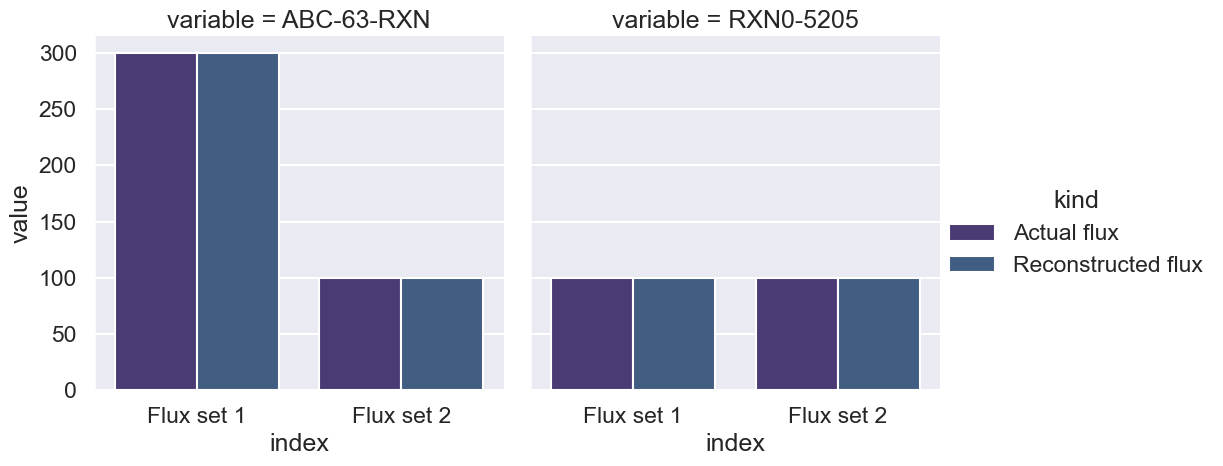

In [52]:
sns.catplot(x="index", y="value", hue="kind", col="variable", kind="bar", data=df_reconstr_comp, height=5, aspect=1, col_wrap=2)
plt.savefig("flux_set_comparison.svg")

In [53]:
reconstructed_vE = np.zeros(vE.shape)

for j in range(n_flux_set):
    sat_expr = []
    fwd_sat = np.zeros(n_rxn)
    back_sat = np.zeros(n_rxn)
    sat = np.zeros(n_rxn)

    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)


        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        sat_expr.append(           [ (C_alpha @ y_f.value[j, :].flatten())[d_alpha == i] ,
                                     (C_beta @ y_r.value[j, :].flatten())[d_beta == i],
                                     0,
                                     #-1*np.ones(n_lse_terms - n_term + 1)
                                   ]
                       )
        fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[j, Km_s_idx].flatten())) 
        back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[j, Km_p_idx].flatten()))



    for i, rxn in enumerate(sat_expr):
        s = 0

        for term in rxn:
            s += np.sum(np.exp(term))

        sat[i] = (s)

    reconstr = np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat
    print(reconstr)
    reconstructed_vE[j, :] = reconstr

[300.00036479 100.00013873]
[100.00013939 100.00012445]


In [54]:
dmdt_ext = S @ reconstructed_vE.T
dmdt_ext

array([[-2.00000226e+02, -1.49365546e-05],
       [-4.00000504e+02, -2.00000264e+02],
       [-4.00000504e+02, -2.00000264e+02],
       [ 2.00000226e+02,  1.49365546e-05],
       [ 4.00000504e+02,  2.00000264e+02],
       [ 4.00000504e+02,  2.00000264e+02],
       [ 4.00000504e+02,  2.00000264e+02]])

# Function that calculates fluxes from concentrations and basic parameters